<a href="https://colab.research.google.com/github/crisalex25/TFM_HydroMLGenerationOptimization/blob/main/TFM_Optimizaci%C3%B3n_de_la_generaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo de Fin de Master**
## **Máster Universitario en Inteligencia Artificial para el Sector de la Energía y las Infraestructuras**
Optimización de generación en centrales hidroeléctricas mediante técnicas de aprendizaje automático

#Optimización Central Loreto

##Algoritmo Genético


In [1]:
import random
from tabulate import tabulate

## Definición de funciones

# Función para calcular los caudales turbinados y disponibles
def calcular_caudal_turbinado(potencia_unit):
    caudal_turbinado = max(0.0005 * potencia_unit - 0.0154, 0.0)
    return round(caudal_turbinado, 2)

# Función para calcular el costo del déficit de generación
def calcular_costo_deficit(generacion, demanda, costo_horario):
    deficit = generacion - demanda
    if deficit < 0:
        costo_deficit = abs(deficit) * costo_horario / 100
    else:
        costo_deficit = 0

    return round(costo_deficit, 2)


# Función para generar una solución inicial de generación
def generar_solucion_inicial(capacidad_unit, rango_horario):
    generacion_inicial = []
    for hora in rango_horario:
        # Generar una potencia aleatoria entre 500 y la capacidad máxima
        potencia_unit = max(random.uniform(0, capacidad_unit), 500)

        caudal_turbinado = calcular_caudal_turbinado(potencia_unit)

        while caudal_turbinado > caudal_disponible:
            potencia_unit = max(random.uniform(0, capacidad_unit), 500)
            caudal_turbinado = calcular_caudal_turbinado(potencia_unit)

        generacion_inicial.append(potencia_unit)

    return generacion_inicial

def generar_poblacion_inicial(capacidad_unit, rango_horario, tam_poblacion):
    poblacion = []
    for _ in range(tam_poblacion):
        individuo = generar_solucion_inicial(capacidad_unit, rango_horario)
        poblacion.append(individuo)
    return poblacion

# Función para realizar el crossover entre dos individuos
def crossover(padre1, padre2):
    punto_corte = random.choice(range(len(padre1)))
    hijo2 = padre2[:punto_corte] + padre1[punto_corte:]
    return hijo2

# Función para aplicar mutación a un individuo
def mutacion(individuo, prob_mutacion, capacidad_unit):
    for i in range(len(individuo)):
        if random.random() < prob_mutacion:
            nueva_potencia_unit = max(random.uniform(0, capacidad_unit), 500)

            caudal_turbinado = calcular_caudal_turbinado(nueva_potencia_unit)

            while caudal_turbinado > caudal_disponible:
                nueva_potencia_unit = max(random.uniform(0, capacidad_unit), 500)
                caudal_turbinado = calcular_caudal_turbinado(nueva_potencia_unit)

            individuo[i] = nueva_potencia_unit
    return individuo

# Función principal para aplicar el algoritmo genético
def aplicar_algoritmo_genetico(capacidad_unit, demanda_energia, costo_horario, rango_horario, tam_poblacion, prob_crossover, prob_mutacion, num_generaciones):
    poblacion = generar_poblacion_inicial(capacidad_unit, rango_horario, tam_poblacion)

    for _ in range(num_generaciones):
        costos = []

        for generacion in poblacion:
            costo_generacion = sum(
                calcular_costo_deficit(
                    generacion[i], demanda_energia[i], costo_horario[i]
                )
                for i in range(len(rango_horario))
            )
            costos.append(costo_generacion)

        idx_mejor = min(range(len(costos)), key=lambda k: costos[k])
        padre = poblacion[idx_mejor]

        hijo = crossover(padre, padre)

        hijo_mutado = mutacion(hijo, prob_mutacion, capacidad_unit)

        idx_peor = max(range(len(costos)), key=lambda k: costos[k])
        poblacion[idx_peor] = hijo_mutado

    mejor_idx = min(range(len(costos)), key=lambda k: costos[k])
    mejor_generacion = poblacion[mejor_idx]
    mejor_costo_deficit = costos[mejor_idx]

    return mejor_generacion, mejor_costo_deficit

In [2]:
# Definición de variables y parámetros
caudal_disponible = 0.95
rango_horario = range(24)
capacidad_unit = 2150
costo_horario = [6.19, 8.39, 6.19, 6.19, 5.35, 6.48, 5.35, 5.35, 6.19, 6.19, 6.19, 6.48,
                  6.19, 6.48, 6.19, 6.48, 6.19, 6.19, 9.46, 9.46, 8.96, 6.19, 6.19, 6.19]

demanda_gc = [2114, 2175, 2095, 2248, 2213, 2170, 2172, 2286, 2289, 2213, 2181, 2303,
              2374, 2332, 2200, 2264, 2251, 2162, 2261, 2120, 2028, 2136, 2183, 2198]

tam_poblacion = 2000
prob_crossover = 0.8
prob_mutacion = 0.2
num_generaciones = 2000

# Aplicar el algoritmo genético
mejor_generacion, mejor_costo_deficit = aplicar_algoritmo_genetico(
    capacidad_unit,
    demanda_gc,
    costo_horario,
    rango_horario,
    tam_poblacion,
    prob_crossover,
    prob_mutacion,
    num_generaciones,
)

In [3]:
# Crear tabla de resultados
tabla_resultados = []
for hora, generacion in enumerate(mejor_generacion):
    caudal_turbinado = calcular_caudal_turbinado(generacion)
    costo_deficit = calcular_costo_deficit(
        generacion, demanda_gc[hora], costo_horario[hora]
    )
    fila = [
        hora,
        demanda_gc[hora],
        generacion,
        caudal_turbinado,
        caudal_disponible,
        costo_deficit,
        costo_horario[hora]
    ]
    tabla_resultados.append(fila)

# Mostrar tabla de resultados
headers = ["Hora", "Demanda", "Generación U3", "Caudal Turb", "Caudal Disp", "Costo Total Défic", "Precio kwh ctvs"]
tabla = tabulate(tabla_resultados, headers, tablefmt="grid")
print(tabla)

# Calcular el costo total del déficit acumulado
costo_total_deficit = sum(row[5] for row in tabla_resultados)

# Mostrar el costo total del déficit acumulado
print("\nCosto total del déficit acumulado: ${:.2f}".format(costo_total_deficit))

+--------+-----------+-----------------+---------------+---------------+---------------------+-------------------+
|   Hora |   Demanda |   Generación U3 |   Caudal Turb |   Caudal Disp |   Costo Total Défic |   Precio kwh ctvs |
+========+===========+=================+===============+===============+=====================+===================+
|      0 |      2114 |         1927.56 |          0.95 |          0.95 |               11.54 |              6.19 |
+--------+-----------+-----------------+---------------+---------------+---------------------+-------------------+
|      1 |      2175 |         1805.26 |          0.89 |          0.95 |               31.02 |              8.39 |
+--------+-----------+-----------------+---------------+---------------+---------------------+-------------------+
|      2 |      2095 |          500    |          0.23 |          0.95 |               98.73 |              6.19 |
+--------+-----------+-----------------+---------------+---------------+--------

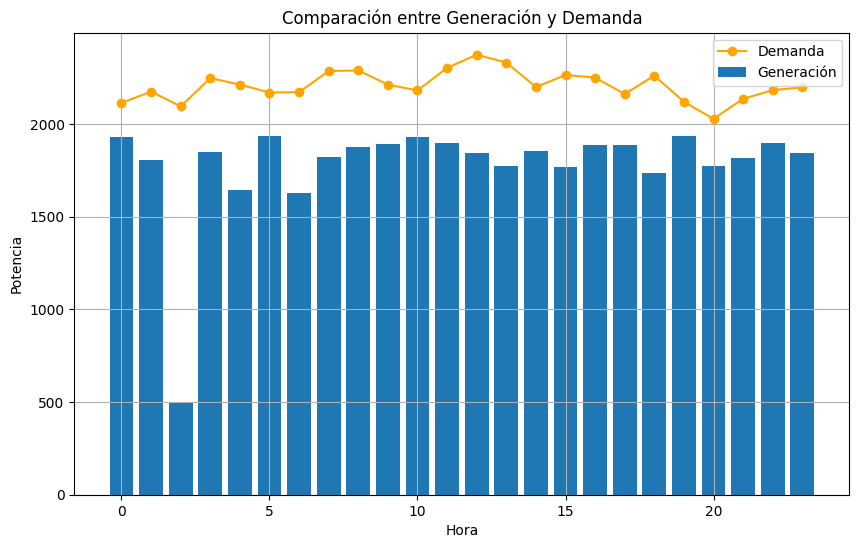

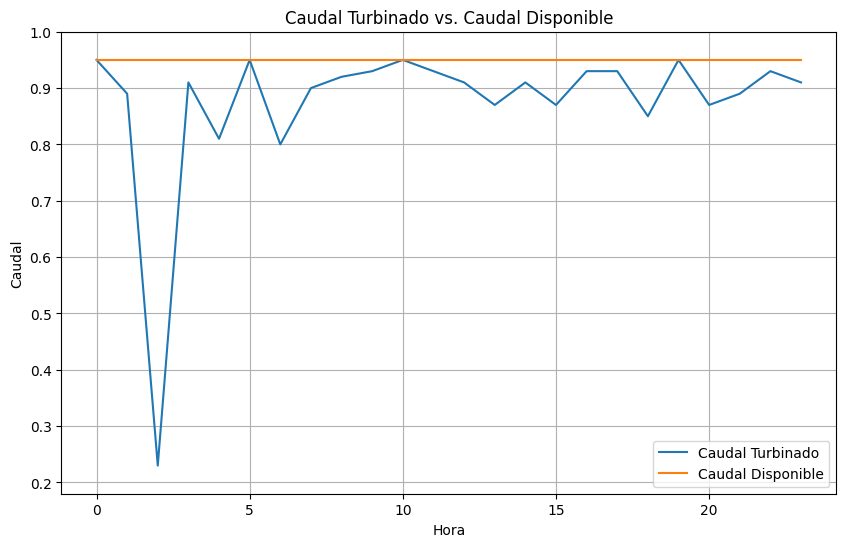

In [4]:

import matplotlib.pyplot as plt
import numpy as np

# Función para graficar la comparación entre generación y demanda en forma de barras
def graficar_generacion_vs_demanda(rango_horario, generacion, demanda):
    plt.figure(figsize=(10, 6))
    plt.bar(rango_horario, generacion, label='Generación')
    plt.plot(rango_horario, demanda, label='Demanda', marker='o', color='orange')
    plt.xlabel('Hora')
    plt.ylabel('Potencia')
    plt.title('Comparación entre Generación y Demanda')
    plt.legend()
    plt.grid(True)
    plt.ylim(0)  # Ajustar el límite inferior del eje Y a 0
    plt.show()

# Función para graficar el caudal turbado y caudal disponible centrados
def graficar_caudales(rango_horario, caudal_turbinado, caudal_disponible):
    plt.figure(figsize=(10, 6))
    plt.plot(rango_horario, caudal_turbinado, label='Caudal Turbinado')
    plt.plot(rango_horario, caudal_disponible, label='Caudal Disponible')
    plt.xlabel('Hora')
    plt.ylabel('Caudal')
    plt.title('Caudal Turbinado vs. Caudal Disponible')
    plt.legend()
    plt.grid(True)

    # Encontrar el valor máximo entre los caudales para centrar la gráfica
    max_caudal = max(max(caudal_turbinado), max(caudal_disponible)) + 0.05
    min_caudal = min(min(caudal_turbinado), min(caudal_disponible)) - 0.05
    plt.ylim(min_caudal, max_caudal)  # Ajustar los límites del eje Y
    plt.show()

# Obtener los valores de caudal turbinado y caudal disponible
caudales_turbinados = [calcular_caudal_turbinado(generacion) for generacion in mejor_generacion]
caudales_disponibles = [caudal_disponible] * len(rango_horario)  # Replicar el valor para cada hora

# Convertir el rango horario en una lista para usarlo como coordenadas en la gráfica de barras
rango_horario_lista = list(rango_horario)

# Graficar la comparación entre generación y demanda en forma de barras
graficar_generacion_vs_demanda(rango_horario_lista, mejor_generacion, demanda_gc)

# Graficar el caudal turbado y caudal disponible centrados
graficar_caudales(rango_horario_lista, caudales_turbinados, caudales_disponibles)


#Optimización Central Papallacta

##Algoritmo Genético


In [5]:
import random
from tabulate import tabulate

# Función para calcular los caudales turbinados y disponibles
def calcular_caudal_turbinado(generator_number, potencia_unit):
    if generator_number == 1:
        caudal_turbinado = max(0.001118 * potencia_unit - 0.0007556, 0.0)
    else:
        caudal_turbinado = max(0.000835 * potencia_unit + 0.001027, 0.0)
    return round(caudal_turbinado, 2)

# Función para calcular el costo del déficit de generación
def calcular_costo_deficit(generacion, demanda, costo_horario):
    deficit = generacion - demanda
    if deficit < 0:
        costo_deficit = abs(deficit) * costo_horario / 100
    else:
        costo_deficit = 0

    return round(costo_deficit, 2)

# Función para generar una solución inicial de generación
def generar_solucion_inicial(capacidad_unit, rango_horario):
    generacion_inicial = []
    for hora in rango_horario:
        # Generar una potencia aleatoria entre 500 y la capacidad máxima del generador 2
        potencia_unit_2 = max(random.uniform(1600, 4200), 1600)
        caudal_turbinado_2 = calcular_caudal_turbinado(2, potencia_unit_2)

        max_potencia_unit_1 = min(1850, max(4100 - potencia_unit_2, 0))  # Restricción del generador 1
        potencia_unit_1 = max(random.uniform(400, max_potencia_unit_1), 400)
        caudal_turbinado_1 = calcular_caudal_turbinado(1, potencia_unit_1)

        while (caudal_turbinado_1 + caudal_turbinado_2) > caudal_disponible:
            potencia_unit_2 = max(random.uniform(1600, 4200), 1600)
            caudal_turbinado_2 = calcular_caudal_turbinado(2, potencia_unit_2)
            max_potencia_unit_1 = min(1850, max(4100 - potencia_unit_2, 0))
            potencia_unit_1 = max(random.uniform(400, max_potencia_unit_1), 400)
            caudal_turbinado_1 = calcular_caudal_turbinado(1, potencia_unit_1)

        generacion_inicial.append((potencia_unit_1, potencia_unit_2))

    return generacion_inicial

def generar_poblacion_inicial(capacidad_unit, rango_horario, tam_poblacion):
    poblacion = []
    for _ in range(tam_poblacion):
        individuo = generar_solucion_inicial(capacidad_unit, rango_horario)
        poblacion.append(individuo)
    return poblacion

def crossover(padre1, padre2):
    punto_corte = random.choice(range(len(padre1)))
    hijo2 = padre2[:punto_corte] + padre1[punto_corte:]
    return hijo2

def mutacion(individuo, prob_mutacion, capacidad_unit):
    for i in range(len(individuo)):
        if random.random() < prob_mutacion:
            potencia_unit_1, potencia_unit_2 = individuo[i]

            nueva_potencia_unit_2 = max(random.uniform(1600, 4200), 1600)
            caudal_turbinado_2 = calcular_caudal_turbinado(2, nueva_potencia_unit_2)

            max_potencia_unit_1 = min(1850, max(4100 - nueva_potencia_unit_2, 0))
            nueva_potencia_unit_1 = max(random.uniform(400, max_potencia_unit_1), 400)
            caudal_turbinado_1 = calcular_caudal_turbinado(1, nueva_potencia_unit_1)

            while (caudal_turbinado_1 + caudal_turbinado_2) > caudal_disponible:
                nueva_potencia_unit_2 = max(random.uniform(1600, 4200), 1600)
                caudal_turbinado_2 = calcular_caudal_turbinado(2, nueva_potencia_unit_2)
                max_potencia_unit_1 = min(1850, max(4100 - nueva_potencia_unit_2, 0))
                nueva_potencia_unit_1 = max(random.uniform(400, max_potencia_unit_1), 400)
                caudal_turbinado_1 = calcular_caudal_turbinado(1, nueva_potencia_unit_1)

            individuo[i] = (nueva_potencia_unit_1, nueva_potencia_unit_2)
    return individuo

def aplicar_algoritmo_genetico(capacidad_unit, demanda_energia, costo_horario, rango_horario, tam_poblacion, prob_crossover, prob_mutacion, num_generaciones):
    poblacion = generar_poblacion_inicial(capacidad_unit, rango_horario, tam_poblacion)

    for _ in range(num_generaciones):
        costos = []

        for generacion in poblacion:
            costo_generacion = sum(
                calcular_costo_deficit(
                    generacion[i][0] + generacion[i][1], demanda_energia[i], costo_horario[i]
                )
                for i in range(len(rango_horario))
            )
            costos.append(costo_generacion)

        idx_mejor = min(range(len(costos)), key=lambda k: costos[k])
        padre = poblacion[idx_mejor]

        hijo = crossover(padre, padre)

        hijo_mutado = mutacion(hijo, prob_mutacion, capacidad_unit)

        idx_peor = max(range(len(costos)), key=lambda k: costos[k])
        poblacion[idx_peor] = hijo_mutado

    mejor_idx = min(range(len(costos)), key=lambda k: costos[k])
    mejor_generacion = poblacion[mejor_idx]
    mejor_costo_deficit = costos[mejor_idx]

    return mejor_generacion, mejor_costo_deficit

# Definición de variables y parámetros
caudal_disponible = 2.35
rango_horario = range(24)
capacidad_unit = 2150
costo_horario = [6.19, 8.39, 6.19, 6.19, 5.35, 6.48, 5.35, 5.35, 6.19, 6.19, 6.19, 6.48,
                  6.19, 6.48, 6.19, 6.48, 6.19, 6.19, 9.46, 9.46, 8.96, 6.19, 6.19, 6.19]

demanda_gc = [4811, 4787, 4778, 4780, 4856, 4878, 4853, 4901, 5082, 5250, 5292, 5305,
              5103, 5219, 5266, 5258, 5311, 5138, 4989, 4876, 4745, 4876, 4833, 4845]

tam_poblacion = 2000
prob_crossover = 0.8
prob_mutacion = 0.2
num_generaciones = 2000

# Aplicar el algoritmo genético
mejor_generacion, mejor_costo_deficit = aplicar_algoritmo_genetico(
    capacidad_unit,
    demanda_gc,
    costo_horario,
    rango_horario,
    tam_poblacion,
    prob_crossover,
    prob_mutacion,
    num_generaciones,
)

In [6]:
# Crear tabla de resultados
tabla_resultados = []
for hora, (generacion_1, generacion_2) in enumerate(mejor_generacion):
    caudal_turbinado_1 = calcular_caudal_turbinado(1, generacion_1)
    caudal_turbinado_2 = calcular_caudal_turbinado(2, generacion_2)
    caudal_total_turbinado = caudal_turbinado_1 + caudal_turbinado_2

    costo_deficit = calcular_costo_deficit(
        generacion_1 + generacion_2, demanda_gc[hora], costo_horario[hora]
    )

    fila = [
        hora,
        demanda_gc[hora],
        generacion_1,
        generacion_2,
        caudal_turbinado_1,
        caudal_turbinado_2,
        caudal_total_turbinado,
        caudal_disponible,
        costo_deficit,
        costo_horario[hora]
    ]
    tabla_resultados.append(fila)

# Mostrar tabla de resultados
headers = ["Hora", "Demanda", "Generación G1", "Generación G2", "Caudal Turb G1", "Caudal Turb G2", "Caudal Turb Total", "Caudal Disp", "Costo Total Défic", "Precio kwh ctvs"]
tabla = tabulate(tabla_resultados, headers, tablefmt="grid")
print(tabla)

# Calcular el costo total del déficit acumulado
costo_total_deficit = sum(row[8] for row in tabla_resultados)

# Mostrar el costo total del déficit acumulado
print("\nCosto total del déficit acumulado: ${:.2f}".format(costo_total_deficit))


+--------+-----------+-----------------+-----------------+------------------+------------------+---------------------+---------------+---------------------+-------------------+
|   Hora |   Demanda |   Generación G1 |   Generación G2 |   Caudal Turb G1 |   Caudal Turb G2 |   Caudal Turb Total |   Caudal Disp |   Costo Total Défic |   Precio kwh ctvs |
+========+===========+=================+=================+==================+==================+=====================+===============+=====================+===================+
|      0 |      4811 |         614.394 |         1986.63 |             0.69 |             1.66 |                2.35 |          2.35 |              136.8  |              6.19 |
+--------+-----------+-----------------+-----------------+------------------+------------------+---------------------+---------------+---------------------+-------------------+
|      1 |      4787 |         520.826 |         2122.09 |             0.58 |             1.77 |                2.3